In [22]:
import botorch
import math
import torch
import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan

from gpytorch.mlls import ExactMarginalLogLikelihood

from torch.optim import SGD

In [8]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

cpu


In [29]:
#use regular spaced points on the interval [0, 1] -> here 15 equally spaced points between 0 and 1
train_X = torch.linspace(0, 3, 20, dtype=dtype, device=device)
#training data needs to be explicitly multi-dimensional, here from 1-dimensional to 2-dimensional
train_X = train_X.unsqueeze(1)
#sample observed values and add some synthetic noise
train_Y = train_X * torch.sin(train_X * (2 * math.pi)) + 0.1 * torch.randn_like(train_X)

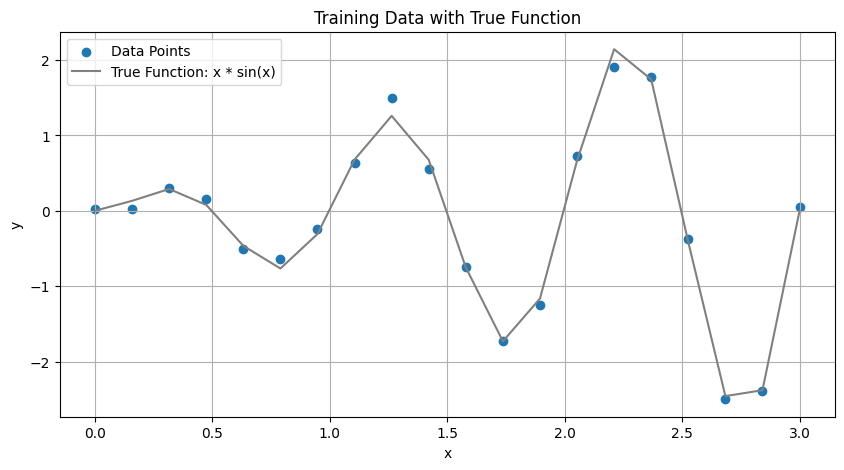

In [30]:
#Plotting the noise data points and the original function x*sin(x)
plt.figure(figsize=(10, 5))
plt.scatter(train_X.cpu().numpy(), train_Y.cpu().numpy(), label='Data Points')
plt.plot(train_X.cpu().numpy(), train_X.cpu().numpy() * torch.sin(train_X * (2 * math.pi)).cpu().numpy(), color='grey', label='True Function: x * sin(x)')
plt.title('Training Data with True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
#initilize GP Model: SingleTaskGP from botorch -> Training inputs "train_X" and outputs ""
model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
#set the noise constraints -> minimum lower bound for the raw noise here 
#(noise in the data that cannot be explained by the models underlying function)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\Moritz\anaconda3\envs\TL_GP\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.1366]), std = tensor([1.2133])). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [32]:
#sets up the optimization process to find the best model parameters:
#maximize likelihood function to fit the model parameters best to the observed data
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

In [33]:
#initilize stochastic gradient descent optimizer to update the parameters of the model
optimizer = SGD([{"params": model.parameters()}], lr=0.1)

In [42]:
#set train epochs
NUM_EPOCHS = 150

#set model to train
model.train()

for epoch in range(NUM_EPOCHS):
    #clear gradients
    optimizer.zero_grad()
    #forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    #Compute negative marginal log likelihood
    loss = -mll(output, model.train_targets)
    #back prop gradients
    loss.backward()
    #print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} "
            f"noise: {model.likelihood.noise.item():>4.3f}"
        )
    optimizer.step()

Epoch  10/150 - Loss: 1.499 lengthscale: 0.304 noise: 0.030
Epoch  20/150 - Loss: 1.497 lengthscale: 0.305 noise: 0.029
Epoch  30/150 - Loss: 1.496 lengthscale: 0.306 noise: 0.028
Epoch  40/150 - Loss: 1.494 lengthscale: 0.307 noise: 0.027
Epoch  50/150 - Loss: 1.493 lengthscale: 0.308 noise: 0.027
Epoch  60/150 - Loss: 1.491 lengthscale: 0.309 noise: 0.026
Epoch  70/150 - Loss: 1.490 lengthscale: 0.310 noise: 0.025
Epoch  80/150 - Loss: 1.489 lengthscale: 0.311 noise: 0.024
Epoch  90/150 - Loss: 1.487 lengthscale: 0.312 noise: 0.024
Epoch 100/150 - Loss: 1.486 lengthscale: 0.313 noise: 0.023
Epoch 110/150 - Loss: 1.485 lengthscale: 0.314 noise: 0.022
Epoch 120/150 - Loss: 1.484 lengthscale: 0.315 noise: 0.022
Epoch 130/150 - Loss: 1.483 lengthscale: 0.316 noise: 0.021
Epoch 140/150 - Loss: 1.482 lengthscale: 0.317 noise: 0.020
Epoch 150/150 - Loss: 1.481 lengthscale: 0.317 noise: 0.020


In [43]:
#set model (and likelihood)
model.eval();

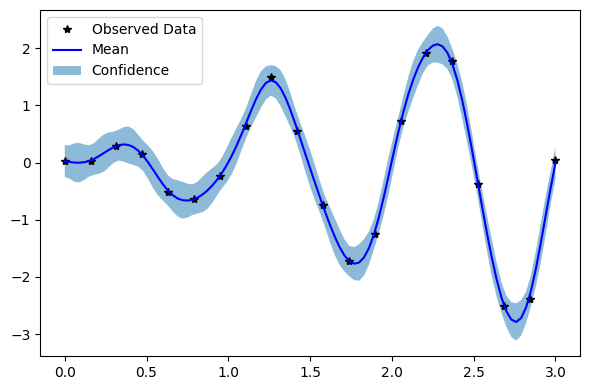

In [44]:
%matplotlib inline

#Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
#test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 3, 101, dtype=dtype, device=device)
#no need for gradients
with torch.no_grad():
    #compute posterior
    posterior = model.posterior(test_X)
    #Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    #Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), "k*")
    #Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), "b")
    #Shade between the lower and upper confidence bounds
    ax.fill_between(
        test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5
    )
ax.legend(["Observed Data", "Mean", "Confidence"])
plt.tight_layout()